<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>
<h1 align="center"><font size="5">Judy George Final Assignment ML Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.cluster import KMeans
import random
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


(note: cannot install wget or use !wget code !wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv)

### Load Data From CSV File


In [2]:
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

### Convert to date time object


In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [6]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y


Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - seaborn


The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.11.0-py39h6e9494~ --> pkgs/main::conda-4.11.0-py39hecd8cb5_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


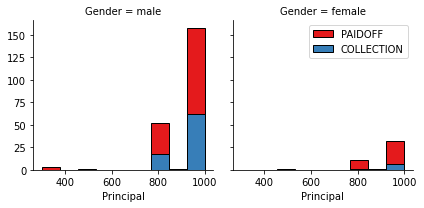

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

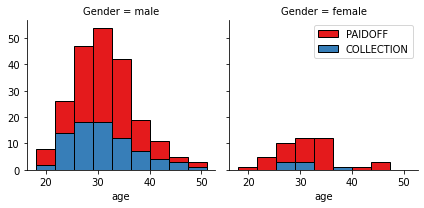

In [14]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

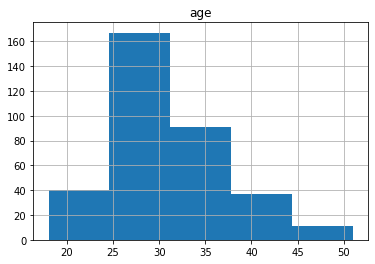

In [15]:
df.hist(column='age', bins=5)

array([[<AxesSubplot:title={'center':'Principal'}>]], dtype=object)

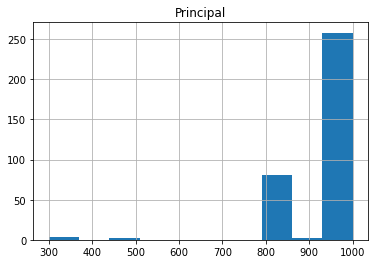

In [16]:
df.hist(column='Principal', bins=10)

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


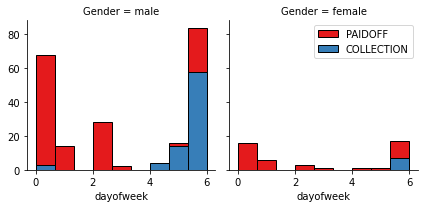

In [17]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [18]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [19]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [20]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True) #JG one way to convert to binary
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [21]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [22]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [23]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1) #create dummy variables
Feature.drop(['Master or Above'], axis = 1,inplace=True) # drop masters or above because the values were even 50/50
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [24]:
X = Feature
X[0:5] 

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [25]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [26]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# 1. Create Models & Reference Standards from Training Data.

## NOTE: Models are created using a randomly sampled 80% training data (train set). Reference standards (evaluation metrics) for the trained model use the remaining 20% training data (train test set).

# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


We will be using train/test split on our decision tree. 
We import train_test_split from sklearn.cross_validation. 

In [27]:
!pip install scikit-learn

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
%matplotlib inline

In [29]:
from sklearn.model_selection import train_test_split

Now train_test_split will return 4 different parameters. We will name them:

X_trainset, X_testset, y_trainset, y_testset

The train_test_split will need the parameters:
X, y, test_size=0.2, and random_state=4.

The X and y are the arrays required before the split, the test_size represents the ratio of the testing dataset, and the random_state ensures that we obtain the same splits.


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [31]:
from sklearn.neighbors import KNeighborsClassifier

I start the algorithm with k=4 for now.

In [32]:
k = 4
#Train Model and Predict  
neigh4 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh4

KNeighborsClassifier(n_neighbors=4)

I use the model to make predictions on the traning test set.

In [33]:
knn_yhat4 = neigh4.predict(X_test)
knn_yhat4[0:5]

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

Evaluation. In multilabel classification, accuracy classification score is a function that computes subset accuracy.  This function is equal to the jaccard_score function. 
Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

In [34]:
from sklearn import metrics  
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh4.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, knn_yhat4))

Train set Accuracy:  0.8152173913043478
Test set Accuracy:  0.6857142857142857


Check on other values for k. K in KNN, is the number of nearest neighbors to examine. It is supposed to be specified by the user. So, how can we choose right value for K? The general solution is to reserve a part of your data for testing the accuracy of the model. Then choose k =1, use the training part for modeling, and calculate the accuracy of prediction using all samples in your test set. Repeat this process, increasing the k, and see which k is the best for your model. I calculate the accuracy of KNN for different values of k starting with k=1 up to k=20.

In [35]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       , 0.68571429,
       0.72857143, 0.72857143, 0.72857143, 0.7       ])

Plot the model accuracy for a different number of neighbors.

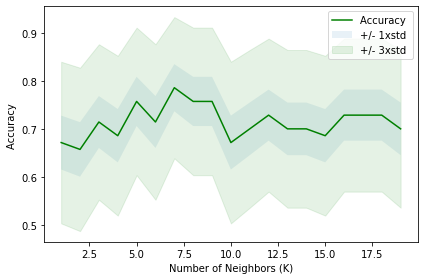

In [36]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [37]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.7857142857142857 with k= 7


In [38]:
#RETRAINED MODEL WITH BEST ACCURACY k=n  SET yhatforknn
k = 7
#Train Model and Predict  
neigh7 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh7


KNeighborsClassifier(n_neighbors=7)

Jaccard similarity coefficient score.

The Jaccard index, or Jaccard similarity coefficient, defined as the size of the intersection divided by the size of the union of two label sets, is used to compare set of predicted labels for a sample to the corresponding set of labels in y_true. 

Compute the F1 score, also known as balanced F-score or F-measure.

The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)

In [39]:
#(optional)
from sklearn import metrics #these eval uses the test data from from the training data as reference standards.

knn_yhat7 = neigh7.predict(X_test)
knn_yhat7 [0:5]

#evaluate  #these eval uses the test data from from the training ("training test") data as reference standards.
from sklearn import metrics

#print("KNN Train set Accuracy: ", metrics.accuracy_score(y_train, neigh7.predict(X_train)))
print("KNN Training Test set Accuracy: ", metrics.accuracy_score(y_test, knn_yhat7))

#print("KNN Train set Jaccard Score: ", metrics.jaccard_score(y_train, neigh7.predict(X_train),pos_label="PAIDOFF"))
print("KNN Training Test set Jaccard Score: ", metrics.jaccard_score(y_test, knn_yhat7,pos_label="PAIDOFF")) #default for binary outcomes

#print("KNN Train set F1 Score: ", metrics.f1_score(y_train, neigh7.predict(X_train),pos_label="PAIDOFF"))
print("KNN Training Test set F1 Score: ", metrics.f1_score(y_test, knn_yhat7,pos_label="PAIDOFF")) #default for binary outcomes

#(optional) evaluation printed for entire test set

KNN Training Test set Accuracy:  0.7857142857142857
KNN Training Test set Jaccard Score:  0.765625
KNN Training Test set F1 Score:  0.8672566371681416


# Decision Tree


We will first create an instance of the DecisionTreeClassifier called drugTree.
Inside of the classifier, specify criterion="entropy" so we can see the information gain of each node. 

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=4)

Next, we will fit the data with the training feature matrix X_trainset and training response vector y_trainset

In [42]:
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

make some predictions on the testing dataset and store it into a variable called predTree. 

In [43]:
predTree = loanTree.predict(X_test)

In [44]:
print('Shape of X training set {}'.format(X_train.shape),'&',' Size of Y training set {}'.format(y_train.shape))
print('Shape of X Training test set {}'.format(X_test.shape),'&',' Size of Y Training test set {}'.format(y_test.shape))

Shape of X training set (276, 8) &  Size of Y training set (276,)
Shape of X Training test set (70, 8) &  Size of Y Training test set (70,)


You can print out predTree and y_testset if you want to visually compare the predictions to the actual values.


In [45]:
print (predTree [0:5])
print (y_test [0:5])

['COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


Evaluation: import metrics from sklearn and check the accuracy of our model. 

In [46]:
from sklearn import metrics  # eval metrics from the training ("training test") data as reference standards.
import matplotlib.pyplot as plt

print("DecisionTrees's Training Test set Accuracy: ", metrics.accuracy_score(y_test, predTree))
print("DecisionTrees's Training Test set Jaccard Score: ", metrics.jaccard_score(y_test, predTree,pos_label="PAIDOFF")) #default for binary outcomes
print("DecisionTrees's Training Test set F1 Score: ", metrics.f1_score(y_test,predTree,pos_label="PAIDOFF")) #default for binary outcomes


DecisionTrees's Training Test set Accuracy:  0.6142857142857143
DecisionTrees's Training Test set Jaccard Score:  0.5714285714285714
DecisionTrees's Training Test set F1 Score:  0.7272727272727274


visualize tree

In [47]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - pydotplus


The following packages will be SUPERSEDED by a higher-priority channel:

  conda              pkgs/main::conda-4.11.0-py39hecd8cb5_0 --> conda-forge::conda-4.11.0-py39h6e9494a_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.



In [48]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

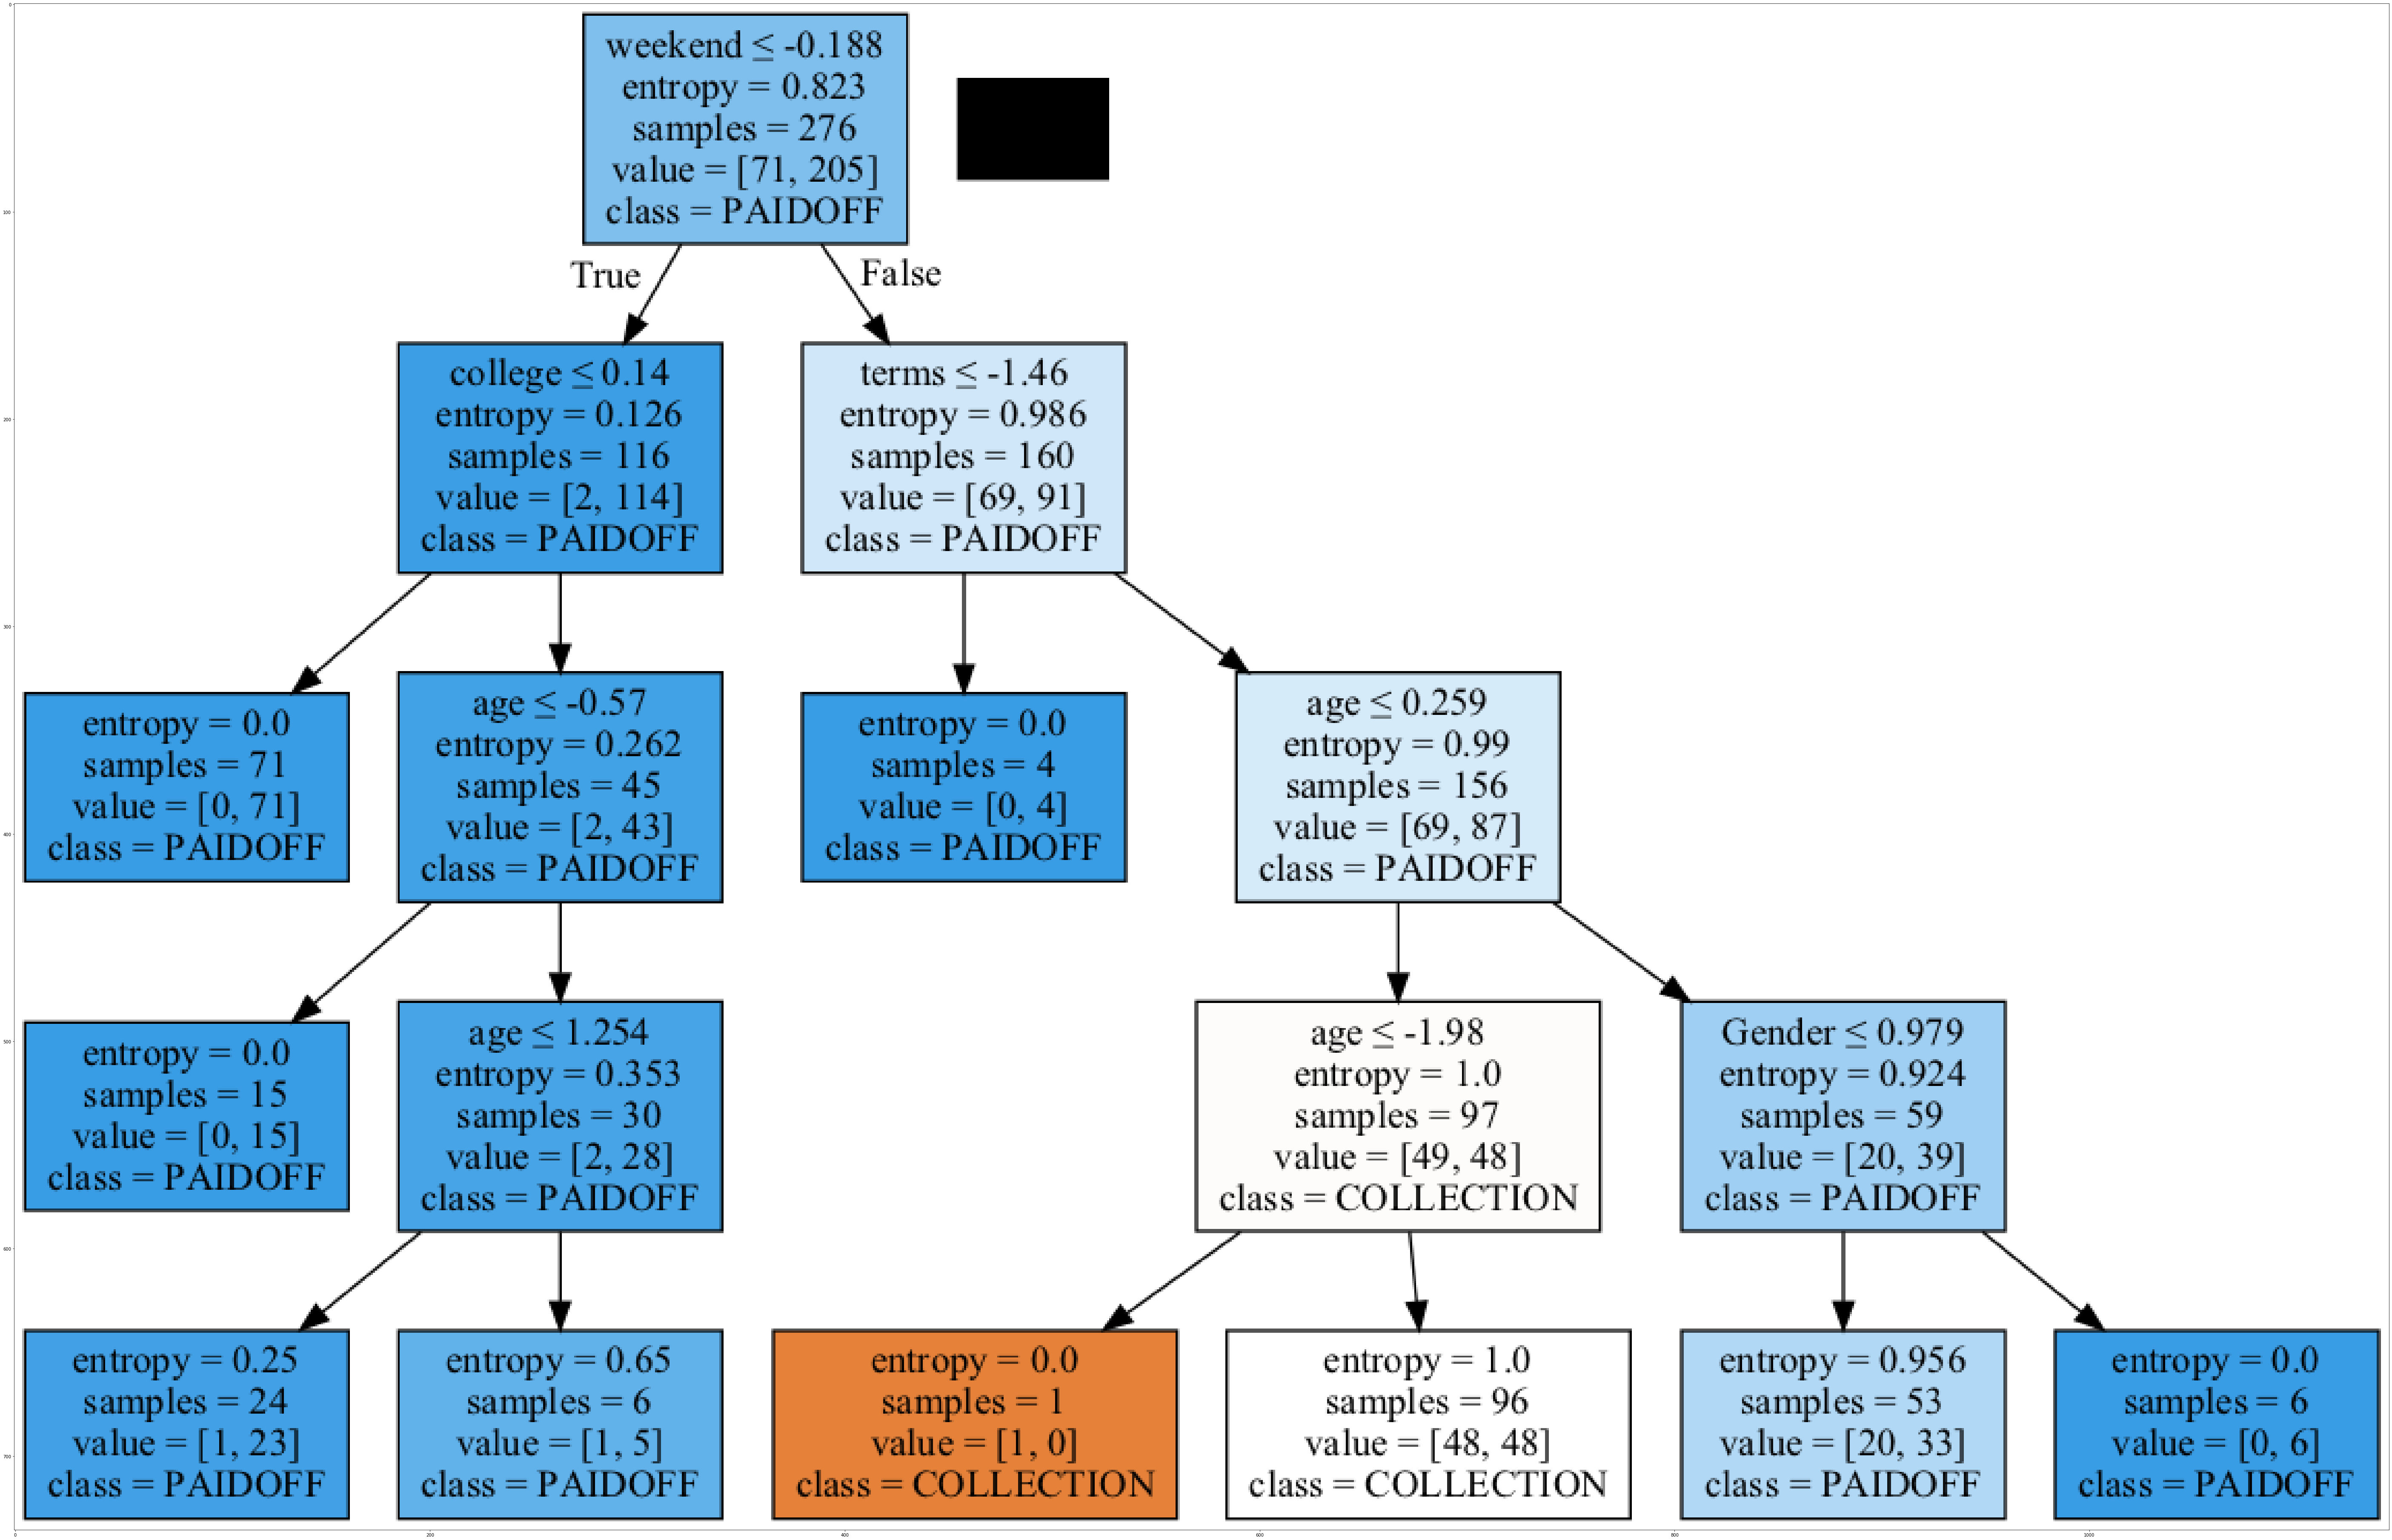

In [49]:
dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns[0:8]
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [50]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [51]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Train Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Train Test set: (70, 8) (70,)


In [52]:
from sklearn import svm

clf_svm = svm.SVC(kernel='rbf') #default is Radial Basis Function
clf_svm.fit(X_train, y_train) 


SVC()

In [53]:
yhat_svm = clf_svm.predict(X_test)
yhat_svm [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [54]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

In [55]:
# eval metrics from the training ("training test") data as reference standards.

print("SVM Train Test set Avg F1-score: " ,f1_score(y_test, yhat_svm, average='weighted'))
print("SVM Train Test set Jaccard score: " ,jaccard_score(y_test, yhat_svm,pos_label='PAIDOFF'))

SVM Train Test set Avg F1-score:  0.7275882012724117
SVM Train Test set Jaccard score:  0.7272727272727273


# Logistic Regression


In [56]:
!pip install scikit-learn  #may not need to re-import, include as reminder of required LR packages

import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [57]:
print ('Train set:', X_train.shape,  y_train.shape) #reminder on the training data set used
print ('Train Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Train Test set: (70, 8) (70,)


LogisticRegression from the Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. The version of Logistic Regression in Scikit-learn, supports regularization. Regularization is a technique used to solve the overfitting problem of machine learning models. C parameter indicates inverse of regularization strength which must be a positive float. Smaller values specify stronger regularization.

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [59]:
yhat_log = LR.predict(X_test)

In [62]:
print (yhat_log [0:5])
print (y_test [0:5])

['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


predict_proba returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), and second column is probability of class 1, P(Y=1|X):

In [63]:
yhat_log_prob = LR.predict_proba(X_test)
yhat_log_prob [0:5]

array([[0.5034238 , 0.4965762 ],
       [0.45206111, 0.54793889],
       [0.30814132, 0.69185868],
       [0.34259428, 0.65740572],
       [0.32025894, 0.67974106]])

Evaluation using Training Test Set

In [64]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

In [65]:
# eval metrics from the training ("training test") data as reference standards.
print("Logistic Regression Train Test set Avg F1-score: " ,f1_score(y_test, yhat_log, average='weighted'))
print("Logistic Regression Train Test set Jaccard score: " ,jaccard_score(y_test, yhat_log,pos_label="PAIDOFF"))


Logistic Regression Train Test set Avg F1-score:  0.6670522459996144
Logistic Regression Train Test set Jaccard score:  0.6764705882352942


Log loss for evaluation. In logistic regression, the output can be the probability of the dichotomous outcome PAIDOFF (vs. Collections). This probability is a value between 0 and 1. Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1.

In [66]:
# eval metrics from the training ("training test") data as reference standards.

from sklearn.metrics import log_loss
print("Logistic Regression Train Test set Log Loss: " ,log_loss(y_test, yhat_log_prob))

Logistic Regression Train Test set Log Loss:  0.5772287609479654


# 2. Model Evaluation using Test set


## NOTE: Evaluation Metrics for Models Created in #1 using the entire Test set sample.




In [67]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


Note cannot load using wget. !wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation


In [68]:
test_df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [69]:
test_df.shape

(54, 10)

In [79]:
#pre-processing: Feature selection/extraction

#Convert to date time object

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

#Convert Categorical features to numerical values

test_df['Gender'].replace(to_replace=['male', 'female'], value=[0, 1], inplace=True)

# Feature binarization to set a threshold value less than day 4

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)

#Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame

test_Feature= test_df[['Principal', 'terms', 'age', 'Gender', 'weekend']]
test_Feature= pd.concat([test_Feature, pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop('Master or Above', axis=1, inplace=True)

#Feature Selection
#Define features of test set

test_X = test_Feature # Features of the Test Set

#Define labels of test set
test_y = test_df['loan_status'].values 

#Normalize Data
#Data Standardization give data zero mean and unit variance
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)

In [80]:
test_X[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [81]:
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

#### K Nearest Neighbor(KNN)  - ALL TEST DATA  Evaluation metrics

In [82]:
#predict with ALL TEST DATA (test_X, test_y)
from sklearn.neighbors import KNeighborsClassifier

knn_yhat7_test = neigh7.predict(test_X)
knn_yhat7_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION'],
      dtype=object)

In [93]:
#evaluate 
from sklearn import metrics

print("KNN TEST SET Jaccard Score: ", metrics.jaccard_score(test_y, knn_yhat7_test,pos_label="PAIDOFF")) 
print("KNN TEST SET Accuracy: ", metrics.accuracy_score(test_y, knn_yhat7_test))
print("KNN TEST SET F1 Score: ", metrics.f1_score(test_y, knn_yhat7_test,average='weighted')) 

KNN TEST SET Jaccard Score:  0.6538461538461539
KNN TEST SET Accuracy:  0.6666666666666666
KNN TEST SET F1 Score:  0.6328400281888654


#### DecisionTree  - ALL TEST DATA  Evaluation metrics

In [84]:
#predict with ALL TEST DATA (test_X, test_y)

predTree1 = loanTree.predict(test_X)


In [92]:
#evaluate
#from sklearn import metrics
#import matplotlib.pyplot as plt

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(test_y, predTree1))
print("DecisionTrees's TEST SET Jaccard Score: ", metrics.jaccard_score(test_y, predTree1,pos_label="PAIDOFF")) #default for binary outcomes
print("DecisionTrees's TEST SET F1 Score: ", metrics.f1_score(test_y,predTree1,pos_label="PAIDOFF")) #default for binary outcomes

DecisionTrees's Accuracy:  0.7222222222222222
DecisionTrees's TEST SET Jaccard Score:  0.6590909090909091
DecisionTrees's TEST SET F1 Score:  0.7945205479452054


#### Support Vector Machines   - ALL TEST DATA  Evaluation metrics

In [86]:
#predict with ALL TEST DATA (test_X, test_y)
from sklearn import svm

yhat_svm1 = clf_svm.predict(test_X)
clf_svm.fit(test_X, test_y) 

SVC()

In [91]:
#evaluate 
#from sklearn.metrics import jaccard_score
#from sklearn.metrics import f1_score

print("SVM Avg F1-score TEST SET: " , f1_score(test_y, yhat_svm1, average='weighted'))
print("SVM Jaccard scoreTEST SET: " , jaccard_score(test_y, yhat_svm1,pos_label="PAIDOFF"))

SVM Avg F1-score TEST SET:  0.7583503077293734
SVM Jaccard scoreTEST SET:  0.78


#### Logistic Regression - ALL TEST DATA Evaluation metrics¶

In [88]:
#predict with ALL TEST DATA (test_X, test_y)
#from sklearn.linear_model import LogisticRegression

yhat_log_test = LR.predict(test_X)
yhat_log_prob_test = LR.predict_proba(test_X)

In [90]:
#evaluate 
print("Logistic Regression TEST SET Avg F1-score: " ,f1_score(test_y, yhat_log_test, average='weighted'))
print("Logistic Regression TEST SET Jaccard score: " ,jaccard_score(test_y, yhat_log_test,pos_label="PAIDOFF"))

#from sklearn.metrics import log_loss
print("Logistic Regression TEST SET Log Loss: " ,log_loss(test_y, yhat_log_prob_test))

Logistic Regression TEST SET Avg F1-score:  0.6604267310789049
Logistic Regression TEST SET Jaccard score:  0.7358490566037735
Logistic Regression TEST SET Log Loss:  0.5672153379912981


# Report

You should be able to report the accuracy of the built model using different evaluation metrics: 
Results based on complete set of Test data (loan_test.csv), n=54 observations.


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.65    | 0.63     | NA      |
| Decision Tree      | 0.66    | 0.79     | NA      |
| SVM                | 0.78    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.66     | 0.57    |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
